In [1]:
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.datasets import ImageFolder
import torch
import json
import matplotlib.pyplot as plt

In [2]:
labasi_data = ImageFolder('../data_retrieval/CDP_data/',ResNet101_Weights.IMAGENET1K_V2.transforms())

In [3]:
model = resnet101()

In [4]:
model.load_state_dict(torch.load('../models/models_weights/resnet101_added_data_worst_signs.pth'))

<All keys matched successfully>

In [5]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
test_loader = torch.utils.data.DataLoader(labasi_data,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [7]:
idx_to_class = {v: k for k, v in labasi_data.class_to_idx.items()}

In [8]:
print(idx_to_class)

{0: 'E_Neo-Assyrian', 1: 'E_Neo-Babylonian', 2: 'GAR_Neo-Assyrian', 3: 'GAR_Neo-Babylonian', 4: 'KA_Neo-Assyrian', 5: 'KA_Neo-Babylonian', 6: 'KI_Neo-Assyrian', 7: 'KI_Neo-Babylonian', 8: 'MEŠ_Neo-Assyrian', 9: 'MEŠ_Neo-Babylonian', 10: 'NI_Neo-Assyrian', 11: 'NI_Neo-Babylonian', 12: 'RU_Neo-Assyrian', 13: 'RU_Neo-Babylonian', 14: 'TA_Neo-Assyrian', 15: 'TA_Neo-Babylonian', 16: 'TI_Neo-Assyrian', 17: 'TI_Neo-Babylonian', 18: 'U₂_Neo-Assyrian', 19: 'U₂_Neo-Babylonian', 20: 'ŠU_Neo-Assyrian', 21: 'ŠU_Neo-Babylonian'}


In [9]:
correct_pred = {classname: 0 for classname in idx_to_class}
total_pred = {classname: 0 for classname in idx_to_class}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if idx_to_class[int(label)] == idx_to_class[(int(prediction))]:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1

In [10]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {idx_to_class[classname]:5s} is {accuracy:.1f} %')

Accuracy for class: E_Neo-Assyrian is 77.8 %
Accuracy for class: E_Neo-Babylonian is 73.9 %
Accuracy for class: GAR_Neo-Assyrian is 93.0 %
Accuracy for class: GAR_Neo-Babylonian is 70.3 %
Accuracy for class: KA_Neo-Assyrian is 93.8 %
Accuracy for class: KA_Neo-Babylonian is 75.0 %
Accuracy for class: KI_Neo-Assyrian is 96.2 %
Accuracy for class: KI_Neo-Babylonian is 70.7 %
Accuracy for class: MEŠ_Neo-Assyrian is 85.2 %
Accuracy for class: MEŠ_Neo-Babylonian is 66.7 %
Accuracy for class: NI_Neo-Assyrian is 88.2 %
Accuracy for class: NI_Neo-Babylonian is 88.0 %
Accuracy for class: RU_Neo-Assyrian is 96.3 %
Accuracy for class: RU_Neo-Babylonian is 55.6 %
Accuracy for class: TA_Neo-Assyrian is 73.3 %
Accuracy for class: TA_Neo-Babylonian is 76.9 %
Accuracy for class: TI_Neo-Assyrian is 87.9 %
Accuracy for class: TI_Neo-Babylonian is 70.0 %
Accuracy for class: U₂_Neo-Assyrian is 56.4 %
Accuracy for class: U₂_Neo-Babylonian is 83.9 %
Accuracy for class: ŠU_Neo-Assyrian is 88.5 %
Accuracy for

In [12]:
print("Overall accuracy: ",sum(correct_pred.values()) / sum(total_pred.values()))

Overall accuracy:  0.824045407636739


In [ ]:
correct_pred = {classname: 0 for classname in idx_to_class}
total_pred = {classname: 0 for classname in idx_to_class}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if idx_to_class[int(label)] + "_Neo-Babylonian" == mapping[str(int(prediction))]:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


In [41]:
def inv_normalize(image):
    for t, m, s in zip(image, torch.Tensor([0.485, 0.456, 0.406]), torch.Tensor([0.229, 0.224, 0.225])):
        t.mul_(s).add_(m)
    return image

torch.Size([3, 224, 224])


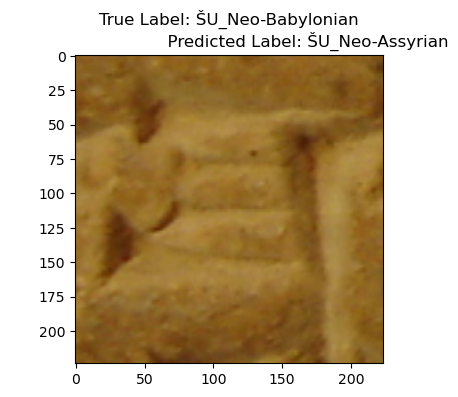

torch.Size([3, 224, 224])


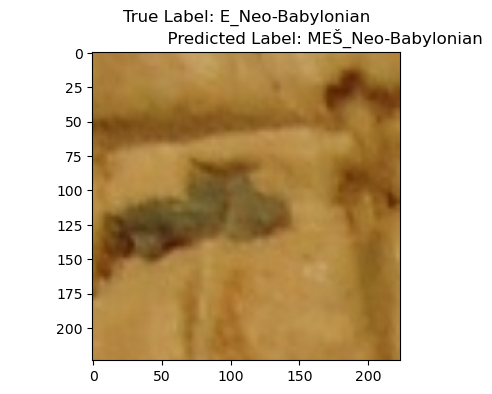

torch.Size([3, 224, 224])


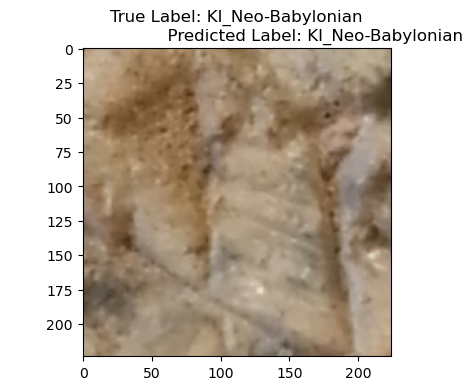

torch.Size([3, 224, 224])


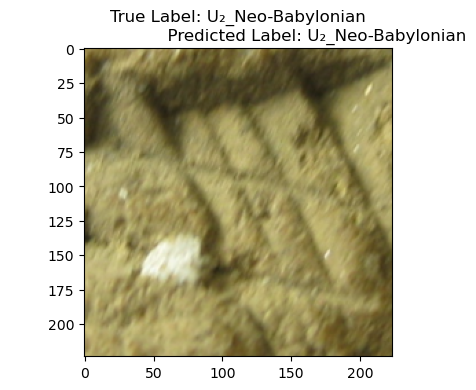

torch.Size([3, 224, 224])


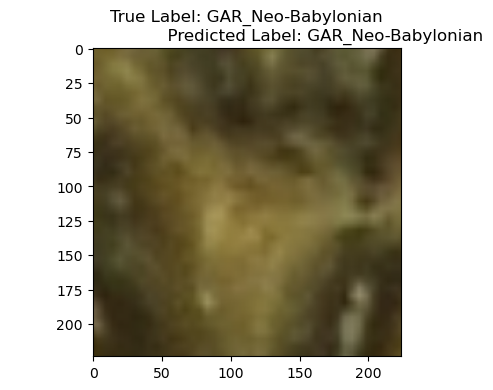

torch.Size([3, 224, 224])


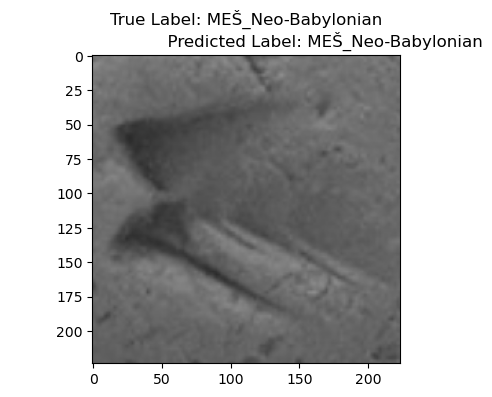

torch.Size([3, 224, 224])


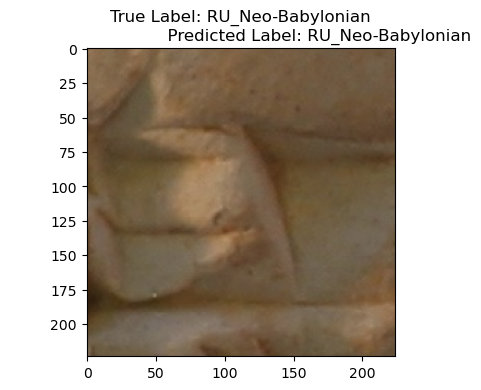

torch.Size([3, 224, 224])


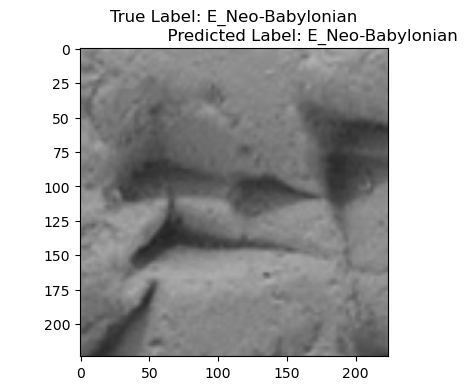

torch.Size([3, 224, 224])


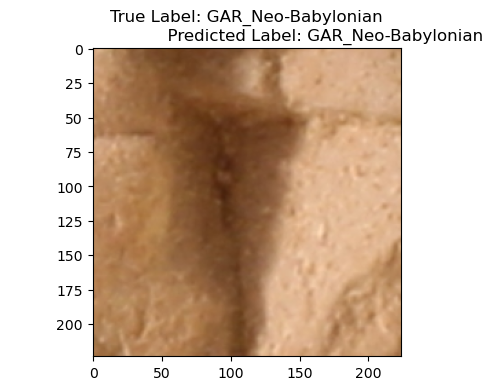

torch.Size([3, 224, 224])


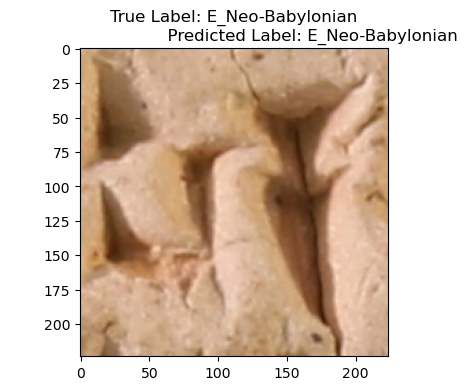

torch.Size([3, 224, 224])


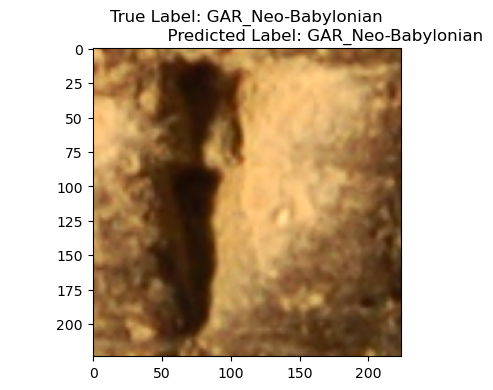

torch.Size([3, 224, 224])


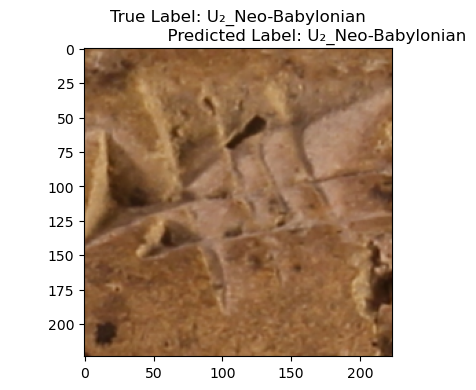

torch.Size([3, 224, 224])


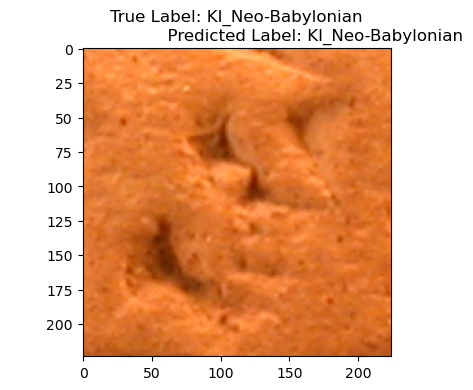

torch.Size([3, 224, 224])


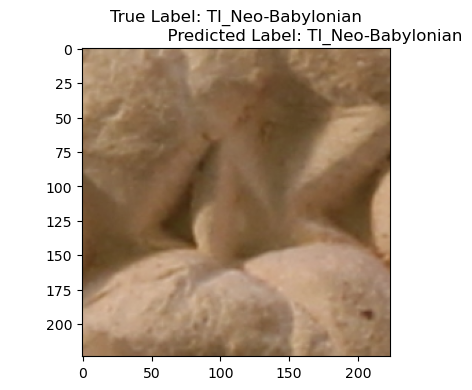

torch.Size([3, 224, 224])


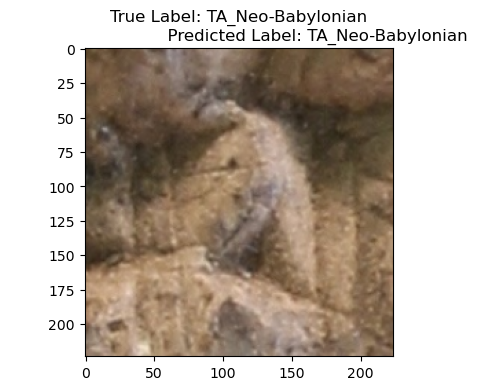

torch.Size([3, 224, 224])


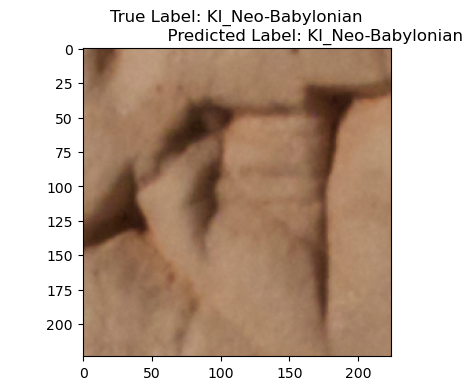

In [42]:
n_pictures = 10
counter = 0
with torch.no_grad():
    for data in test_loader:
        if counter < n_pictures:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for i in range(images.size(0)):
                    counter += 1
                    image = images[i]
                    print(image.shape)
                    label = labels[i].item()
                    predicted_label = predictions[i].item()
                    image = inv_normalize(image).numpy()
                    
                    plt.figure(figsize=(8, 4))
                    plt.imshow(image.transpose(1, 2, 0))
                    plt.title(f"True Label: {idx_to_class[int(label)]}_Neo-Babylonian\n\
                              Predicted Label: {mapping[str(int(predicted_label))]}")
                    plt.show()
